In [1]:
import torch
import torch.nn as nn
import torchvision.datasets
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import SubsetRandomSampler, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters and constants
BATCH_SIZE = 64
NUM_TRAIN = 49000
EPOCHS = 10

PRINT_EVERY = 100

SAVE_MODEL = False

R_MEAN = 0.4914
G_MEAN = 0.4822
B_MEAN = 0.4465
R_STD = 0.2023
G_STD = 0.1994
B_STD = 0.2010

# Use GPU if available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print(device)

cuda


In [3]:
# Set random seed for replicating testing results
np.random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [4]:
# Normalise the dataset
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
            ])
# Augement and normalise the dataset
transform_aug = T.Compose([
                  T.RandomCrop(32, padding=4),
                  T.RandomHorizontalFlip(p=0.5),
                  T.ToTensor(),
                  T.Normalize((R_MEAN, G_MEAN, B_MEAN), (R_STD, G_STD, B_STD))
                ])

In [5]:
# Load CIFAR10
training_dataset   = torchvision.datasets.CIFAR10('data/', train=True,  transform=transform_aug, download=True)
validation_dataset = torchvision.datasets.CIFAR10('data/', train=True,  transform=transform, download=True)
testing_dataset    = torchvision.datasets.CIFAR10('data/', train=False, transform=transform, download=True)


# Create dataloaders
training_data   = DataLoader(training_dataset,   batch_size=BATCH_SIZE, shuffle=False, sampler=SubsetRandomSampler(range(NUM_TRAIN)))
validation_data = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, sampler=SubsetRandomSampler(range(NUM_TRAIN,50000)))
testing_data    = DataLoader(testing_dataset,    batch_size=BATCH_SIZE, shuffle=False)

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified
Files already downloaded and verified


In [6]:
class MyModel3(nn.Module):
    def __init__(self, no_classes=10):
        super(MyModel3, self).__init__()
        
        self.network = nn.Sequential(
                        nn.Conv2d(3,    32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(32,   32, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(32,  64, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
            
                        nn.AvgPool2d(kernel_size=4),
            
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features=no_classes, bias=True)
                       )
        
    def forward(self, x):
        return self.network(x)

In [7]:
class MyModel5(nn.Module):
    def __init__(self, no_classes=10):
        super(MyModel5, self).__init__()
        
        self.network = nn.Sequential(
                        nn.Conv2d(3,    32, kernel_size=5, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(32,   32, kernel_size=5, stride=1, padding=1),
                        nn.BatchNorm2d(32),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(32,  64, kernel_size=5, stride=1, padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1),
                        nn.BatchNorm2d(128),
                        nn.ReLU(inplace=True),
            
                        nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=1),
                        nn.BatchNorm2d(256),
                        nn.ReLU(inplace=True),
            
                        nn.AvgPool2d(kernel_size=5),
            
                        nn.Flatten(),
                        nn.Linear(in_features=256, out_features=no_classes, bias=True)
                       )
        
    def forward(self, x):
        return self.network(x)

In [8]:
def loss_function(preds, y):
    return F.cross_entropy(preds,y)

In [9]:
def evaluate(model):
    model.eval()
    with torch.no_grad():
      correct_preds = 0
      total_preds = 0

      for x_test,y_test in testing_data:
        x_test = x_test.to(device=device, dtype=torch.float32)
        y_test = y_test.to(device=device, dtype=torch.long)

        results = model(x_test)
        _,preds = results.max(1)

        correct_preds += (preds == y_test).sum()
        total_preds += preds.size(0)

      acc = 100.0 * correct_preds / total_preds

      print('Correctly predicted: {}/{}, with accuracy={:.2f}%'.format(correct_preds,total_preds,acc))

In [10]:
# Keep track training losses
valid_losses = [[],[]]

def validate(model, idx):
  model.eval()

  loss = []
  with torch.no_grad():
    for x_validate,y_validate in validation_data:
      x_validate = x_validate.to(device=device, dtype=torch.float32)
      y_validate = y_validate.to(device=device, dtype=torch.long)

      preds = model(x_validate)

      loss.append(loss_function(preds, y_validate).item())

    valid_losses[idx].append(np.mean(loss))

In [11]:
# Keep track training losses
train_losses = [[],[]]

def training(model3, model5, optimiser3, optimiser5):
    for epoch in range(EPOCHS):
        for idx,(x_train,y_train) in enumerate(training_data):
            model3.train()
            model5.train()

            x_train = x_train.to(device=device, dtype=torch.float32)
            y_train = y_train.to(device=device, dtype=torch.long)

            preds3 = model3(x_train)
            preds5 = model5(x_train)

            loss3 = loss_function(preds3, y_train)
            loss5 = loss_function(preds5, y_train)

            optimiser3.zero_grad()
            optimiser5.zero_grad()

            loss3.backward()
            loss5.backward()

            optimiser3.step()
            optimiser5.step()

            if idx % PRINT_EVERY == 0:
                print('Epoch: %d, iteration %d, loss3=%.3f, loss5=%.3f' % (epoch, idx, loss3.item(), loss5.item()))
                train_losses[0].append(loss3.item())
                train_losses[1].append(loss5.item())

                validate(model3, 0)
                validate(model5, 1)

In [12]:
model3 = MyModel3()
model3.to(device=device)
model5 = MyModel5()
model5.to(device=device)

optimiser3 = optim.Adam(model3.parameters())
optimiser5 = optim.Adam(model5.parameters())

In [13]:
training(model3, model5, optimiser3, optimiser5)

# save the model
if SAVE_MODEL:
    torch.save(model3.state_dict(), 'model3.pt')
    torch.save(model5.state_dict(), 'model5.pt')

Epoch: 0, iteration 0, loss3=2.362, loss5=2.374
Epoch: 0, iteration 100, loss3=1.810, loss5=1.734
Epoch: 0, iteration 200, loss3=1.525, loss5=1.609
Epoch: 0, iteration 300, loss3=1.600, loss5=1.608
Epoch: 0, iteration 400, loss3=1.493, loss5=1.595
Epoch: 0, iteration 500, loss3=1.246, loss5=1.334
Epoch: 0, iteration 600, loss3=1.077, loss5=1.029
Epoch: 0, iteration 700, loss3=1.225, loss5=1.463
Epoch: 1, iteration 0, loss3=1.284, loss5=1.300
Epoch: 1, iteration 100, loss3=1.050, loss5=1.109
Epoch: 1, iteration 200, loss3=0.915, loss5=0.935
Epoch: 1, iteration 300, loss3=1.211, loss5=1.086
Epoch: 1, iteration 400, loss3=1.039, loss5=0.913
Epoch: 1, iteration 500, loss3=1.118, loss5=1.010
Epoch: 1, iteration 600, loss3=0.888, loss5=0.920
Epoch: 1, iteration 700, loss3=1.019, loss5=1.087
Epoch: 2, iteration 0, loss3=1.066, loss5=1.032
Epoch: 2, iteration 100, loss3=0.886, loss5=0.930
Epoch: 2, iteration 200, loss3=1.239, loss5=1.191
Epoch: 2, iteration 300, loss3=0.883, loss5=0.823
Epoch:

Correctly predicted: 7806/10000, with accuracy=78.06%
Correctly predicted: 8108/10000, with accuracy=81.08%


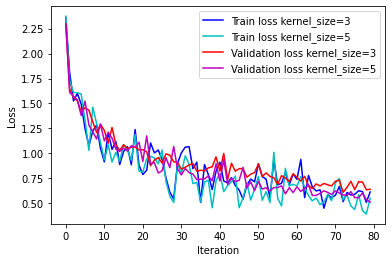

In [14]:
evaluate(model3)
evaluate(model5)

plt.plot(train_losses[0], 'b')
plt.plot(train_losses[1], 'c')
plt.plot(valid_losses[0], 'r')
plt.plot(valid_losses[1], 'm')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(['Train loss kernel_size=3','Train loss kernel_size=5','Validation loss kernel_size=3','Validation loss kernel_size=5'])
plt.show()